In [1]:
import traceback
import argparse
import numpy as np
import os
import uuid
import csv
import sys
import io
import glob
import pprint
import datetime
import time
import random
import tempfile
from google.cloud import storage
from io import StringIO
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from genparams import params
import pypsg
import requests
import os
import numpy as np
import torch
from google.cloud import storage
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="READ/ab2.json"

In [2]:
# Returns a tensor where all rows in which a nan is present are removed
def remove_rows_with_nan(tensor):
    nans = torch.isnan(tensor).nonzero()
    if nans.nelement() > 0:
        rows_with_nan = list(set(list(nans[:, 0].numpy())))
        print('Removing {} row(s) with nan'.format(len(rows_with_nan)))
        buffer = torch.Tensor()
        for i in range(tensor.size(0)):
            if i not in rows_with_nan:
                buffer = torch.cat([buffer, tensor[i]])
        return buffer.view(-1, tensor.size(1))
    return tensor

class DataLoader():
    # Initialising
    def __init__(self, data_dir=None, gcs_bucket=None):
        self._data_dir = data_dir

        # If bucket is not given then work with file system
        if gcs_bucket is None:
            self._gcs_enabled = False
            # Get a list of all the files in the training folder
            self._files = glob.glob(os.path.join(self._data_dir, '*.csv'))
            if len(self._files) > 0:
                planets_per_file = self.read_data_from_file(self._files[0]).size(0)
        # If bucket is given work with google cloud bucket
        else:
            self._gcs_enabled = True
            # Get a list of all the blobs in the training folder
            self._files = list(gcs_bucket.list_blobs(prefix=self._data_dir))
            self._files = [file for file in self._files if 'csv' in file.name]
            if len(self._files) > 0:
                planets_per_file = self.read_data_from_blob(self._files[0]).size(0)

        print('Loading data from dir  : {}'.format(data_dir))
        print('Total number of files  : {:,}'.format(len(self._files)))
        if len(self._files) > 0:
            print('Total number of planets: {:,} (assuming {:,} planets per file)'.format(len(self._files) * planets_per_file, planets_per_file))

        # Creating a buffer by creating a Tensor (empty tensor)
        self._buffer = torch.Tensor()
        self.epoch = 1
        self._file_index = 0
        self.num_files = len(self._files)

    # General writing and reading methods reused in later parts of the program
    @staticmethod
    def read_data_from_blob(blob):
        data_string = blob.download_as_string().decode('utf-8')
        # Creating a torch tensor here from a single blob (csv format)
        return torch.from_numpy(pd.read_csv(StringIO(data_string), delimiter='\t', header=None).as_matrix()).float()

    @staticmethod
    def read_data_from_file(file_name):
        # Creating a torch tensor here from a single file (csv format)
        return torch.from_numpy(pd.read_csv(file_name, delimiter='\t', header=None).as_matrix()).float()

    @staticmethod
    def write_data_to_file(data, file_name):
        stream = io.StringIO()
        writer = csv.writer(stream, delimiter='\t', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for i in range(data.size(0)):
            row = data[i].detach().numpy()
            writer.writerow(row)
        with open(file_name, 'w') as file:
            file.write(stream.getvalue())

    @staticmethod
    def write_data_to_blob(data, blob):
        stream = io.StringIO()
        writer = csv.writer(stream, delimiter='\t', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for i in range(data.size(0)):
            row = data[i].detach().numpy()
            writer.writerow(row)
        blob.upload_from_string(stream.getvalue())

    # Dangerous method! return all of your data as single tensor - good for validation set but careful!
    def get_all(self):
        all_data = []
        for file in self._files:
            if self._gcs_enabled:
                data = self.read_data_from_blob(file)
            else:
                data = self.read_data_from_file(file)
            data = remove_rows_with_nan(data)
            all_data.append(data)
        return torch.cat(all_data).numpy()

    # Creating minibatches from the buffer, if buffer does not have ebough rows it will fill the buffer
    def get_minibatch(self, size=64):
        # Check if we have enough rows in the buffer to create a minibatch
        if self._buffer.size(0) >= size:
            # There are enough rows in the buffer
            # Slice the required number of rows as the minibatch to return
            ret = self._buffer[:size]
            # Remove the sliced minibatch rows from the buffer
            self._buffer = self._buffer[size:]
            return ret.numpy()
        else:
            # There are not enough rows in the buffer
            # Start a loop for reading files from the files sequence and adding the rows to the buffer
            buffer_ready = False
            while not buffer_ready:
                if self._gcs_enabled:
                    data = self.read_data_from_blob(self._files[self._file_index])
                else:
                    data = self.read_data_from_file(self._files[self._file_index])
                data = remove_rows_with_nan(data)
                self._buffer = torch.cat([self._buffer, data])

                # Check if the buffer has enough rows now to supply the minibatch
                # If yes, this will terminate the buffer-filling loop
                if self._buffer.size(0) >= size:
                    buffer_ready = True

                # Check if we reached the end of the list of files
                # If yes, rewind to the first file, increment the epoch
                self._file_index += 1
                if self._file_index >= len(self._files):
                    self._file_index = 0
                    self.epoch += 1
            # Recursive call
            return self.get_minibatch(size)

In [3]:
bucket_name = 'inara-debug-4'
gcs_storage_client = storage.Client()
print('Current buckets in the account:')
# List all the available buckets
for bucket in list(gcs_storage_client.list_buckets()):
    print(' ' + bucket.name)
print('Setting root bucket: {} ...'.format(bucket_name))
gcs_bucket = gcs_storage_client.get_bucket(bucket_name)

Current buckets in the account:
 artifacts.astrobiology-team-2.appspot.com
 astrobiology-2-data
 astrobiology-papers
 inara
 inara-debug-1
 inara-debug-2
 inara-debug-3
 inara-debug-4
Setting root bucket: inara-debug-4 ...


In [4]:
train_data_loader = DataLoader('train', gcs_bucket)

Loading data from dir  : train
Total number of files  : 767
Total number of planets: 7,670 (assuming 10 planets per file)


In [5]:
data = train_data_loader.get_minibatch(10000)

Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
Removing 1 row(s) with nan
R

In [7]:
data.shape

(10000, 11554)

In [6]:
import pickle
pickle.dump( data, open( "example_data.p", "wb" ) )

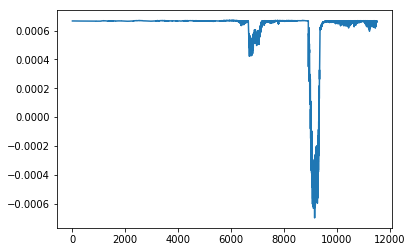

In [8]:
plt.plot(data[0,39:])

In [9]:
import sklearn.linear_model as LR

In [10]:
linreg = LR.LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=1)
# linreg = LR.LogisticRegression(fit_intercept=True, n_jobs=1)


In [16]:
N = 1000
M = 1000

In [12]:
linreg.fit(data[:N,39:],data[:N,27])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [14]:
np.mean((data[:N,27] - linreg.predict(data[:N,39:]))**2)

0.008763374

In [18]:
np.mean((data[N:N+M,27] - linreg.predict(data[N:N+M,39:]))**2)

357.18332

In [19]:
np.mean((data[N:N+M,27] - data[N:N+M,39:].mean())**2)

0.118449226

In [ ]:
test_data = train_data_loader.get_minibatch(100)

In [ ]:
linreg.predict(test_data[:,39:])

In [ ]:
test_data[:,27]

In [ ]:
np.mean((test_data[:,27] - linreg.predict(test_data[:,39:]))**2)

# Add regularisation

In [43]:
linreg_reg = LR.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

In [44]:
linreg_reg.fit(data[:N,39:],data[:N,25])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [45]:
np.mean((data[:N,25] - linreg_reg.predict(data[:N,39:]))**2)

0.00065417984

In [46]:
np.mean((data[N:N+M,25] - linreg_reg.predict(data[N:N+M,39:]))**2)

0.000684116

In [47]:
np.mean((data[N:N+M,25] - data[N:N+M,39:].mean())**2)

0.0018070262

## Multioutput

In [48]:
linreg_reg = LR.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

In [50]:
linreg_reg.fit(data[:N,39:],data[:N,25:36])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [51]:
linreg_reg.predict(data[:N,39:])

(1000, 11)

In [54]:
np.mean((data[N:N+M,25:36] - linreg_reg.predict(data[N:N+M,39:]))**2,0)

array([6.8411580e-04, 2.7178831e-02, 2.7000295e-02, 2.4014432e-02,
       6.3992594e-04, 2.4409495e-05, 2.6832075e-05, 1.8090043e-06,
       2.8402990e-05, 6.6578846e-06, 2.8583012e-08], dtype=float32)